# plt to setfl converter

This Notebook goes through the steps of building a LAMMPS setfl potential file from classic tabulated dat or plt files.




## 1. Setup and initialization

### 1.1. Library imports

potentials can be installed with "pip install potentials" or "conda install potentials -c conda-forge"

In [1]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

import potentials

### 1.2. Utility function(s)

__read_plt()__ reads a tabulated data file and returns the values in the two columns.

In [2]:
def read_plt(pltfile: Path, skip: int = 0):
    """
    Read a plt table in from a file.
    
    Parameters
    ----------
    pltfile : str or Path
        The file name/path of the plt table file to read.
    skip : int, optional
        Indicates how many lines at the beginning of pltfile to skip if it contains header content.
    
    Returns
    -------
    x : list
        The values in the first column, r or rho
    y : list
        The values in the second column, functions of x.
    """
    # Init lists for the value being read
    x = []
    y = []
    
    # Read all file lines
    with open(pltfile) as f:
        lines = f.readlines()
    
    # Read all lines after skip value
    for line in lines[skip:]:
        terms = line.strip().split()
        
        # Ignore empty lines
        if len(terms) == 0:
            continue
        
        # Read values and convert D to E if needed
        x.append(float(terms[0].replace('D', 'E')))
        y.append(float(terms[1].replace('D', 'E')))
        
    return x, y

### 1.3. Initialize a builder object

The builder can be of the following types
- __EAMAlloy__ for eam/alloy files: F(rho) and rho(r) for elements, phi(r) for element pairs
- __EAMFS__ for eam/alloy files: F(rho) for elements, rho(r) and phi(r) for element pairs
- __ADP__ for adp files: F(rho) and rho(r) for elements, phi(r), u(r) and w(r) for element pairs

In [3]:
#builder = potentials.paramfile.EAMAlloy()
#builder = potentials.paramfile.EAMFS()
builder = potentials.paramfile.ADP()

### 1.4. Specify atomic model info

These are the model metadata terms that are included in the parameter files.  NOTE: The final setfl file must have values for all of these terms for each model, but LAMMPS does nothing with the values for number, alat and lattice.

- __symbol__ is the model symbol.
- __number__ is the atomic number.
- __mass__ is the atomic mass for the model.
- __alat__ is a reference a lattice parameter.
- __lattice__ is the reference lattice associated with alat.

In [4]:
builder.set_symbol_info(symbol =  'Al',
                        number =  13,
                        mass =    26.982,
                        alat =    4.05,
                        lattice = 'fcc')

builder.set_symbol_info(symbol =  'Cu',
                        number =  29,
                        mass =    63.546,
                        alat =    3.615,
                        lattice = 'fcc')

for symbol in builder.symbols:
    print(builder.symbol_info(symbol))

{'symbol': 'Al', 'number': 13, 'mass': 26.982, 'alat': 4.05, 'lattice': 'fcc'}
{'symbol': 'Cu', 'number': 29, 'mass': 63.546, 'alat': 3.615, 'lattice': 'fcc'}


### 1.5. Specify root directory

This is the root directory where the parameter files are located.

In [5]:
#root = Path().cwd()              # current working directory
root = Path('F:/website/IPR-website/potentials/Download/2011--Apostol-F-Mishin-Y--Al-Cu/1')   # some other directory

- - -

## 2. $F(\rho)$

Conversion notes:
- From what I've seen, software that uses plt files assume that F(0)=0 so the plt tables typically do not have a rho=0 value. LAMMPS does not assume this and the F(rho) tables begin at rho=0.  For most potentials, F(0)=0.0 as this ensures that the measured potential energy is equal to the cohesive energy.
- For LAMMPS, F(rho) values for all elements use the same rho values that start at rho=0 and go up by Δrho.  
    - If the plt files being converted all have the same rho values and start at rho=0 or rho=Δrho, then the LAMMPS rho values can be set to exactly match these. The F(rho) values from the plt files can then be directly transferred over to the LAMMPS file. 
    - Otherwise, the F(rho) values from the plt files need to be interpolated to generate the corresponding tables in the LAMMPS file. If this is the case, the cutoff needs to be the largest rho out of all of the plt files, and should be tabulated for a large number of points.

### 2.1. Utility function(s)

__read_F_rho__ reads the plt file, appends F(0) = 0 if needed and sets the value to the builder.

In [6]:
def read_F_rho(builder, symbol, pltfile, skip=0, set_rho=False): 
    """
    Reads pltfile for a F_rho table and sets it to the builder
    
    Parameters
    ----------
    builder : EAMAlloy, EAMFS or ADP
        The builder object to set the table values to.
    symbol : str
        The element model symbol to associate with the table.
    pltfile : str or Path
        The file name/path of the plt table file to read.
    skip : int, optional
        Indicates how many lines at the beginning of pltfile to skip if it contains header content.
    set_rho : bool, optional
        If True, the default rho values for the builder will be set
        based on the tabulated rho values found.  NOTE: this assumes that the plt file
        has equally-spaced rho values that start at 0 or deltarho.
    """
    # Read the plt table
    rho, F = read_plt(pltfile, skip=skip)
    
    # Append missing F(0) values
    if not np.isclose(rho[0], 0.0):
        rho = [0.0] + rho
        F = [0.0] + F
        
    # Set tabulated values to builder
    builder.set_F_rho(symbol, table=F, rho=rho)
    
    # Set default rho values of the builder
    if set_rho:
        builder.set_rho(num=len(rho), cutoff=rho[-1])

### 2.2. Set F(rho) from the plt files

In [7]:
# Using set_rho here as both plt files use the same rho values and start with rho=Δrho
read_F_rho(builder, 'Al', Path(root, 'Apostol_Mishin_2011_F_Al.plt'), skip=5)
read_F_rho(builder, 'Cu', Path(root, 'Apostol_Mishin_2011_F_Cu.plt'), skip=5)

### 2.3. Directly set rho values (optional)

If needed, the range of rho values to use in the LAMMPS file can be directly set by specifying values for two out of three of num, cutoff, and delta.

In [8]:
builder.set_rho(num = 10000, delta = 2.2770502180000001e-03)

### 2.4. Plot

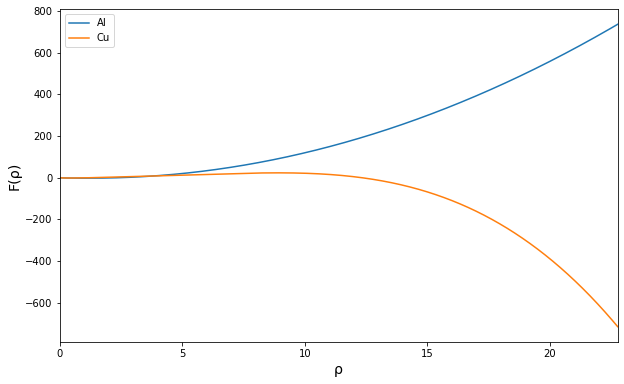

In [9]:
fig = builder.plot_F_rho()
#plt.ylim(-20, 50)
plt.show()

## 3. $\rho(r)$

Conversion notes:
- LAMMPS uses the same r values for all fxn(r) tables which start at 0, incrementally increase by Δr and end at the r cutoff. The plt files each include their own r values meaning that they are not guaranteed to share the same r values, and tend to start at some small non-zero r which is not evenly divisible by Δr. Because of this, interpolation is more often than not required for the fxn(r) tables.
- Define the r values to use in LAMMPS to have the cutoff be the largest r value found in the plt files and a substantial number of interpolation points to give a good representation of the original tables. Since these r values are shared by all fxn(r) tables, this only needs to be done once.
- All fxn(r) tables should ideally go to zero at the cutoff for the corresponding interaction.  However, the plt tables for the interactions that have the largest "global" cutoff often have minuscule values for their final r values. Explicitly setting these values to 0.0 can help keep the functions smooth at the cutoff value.
- fxn(r) values for r less than the first r value in the plt files are technically undefined.  Here, however, the same spline interpolation for the larger r values is used to extrapolate a smooth function in that range.  Alternate conversions in the past either set the smaller fxn(r) to be constant at either fxn(r) at the smallest known r, or to some absurdly large value. The affected small r configurations only matter in extreme conditions, such as radiation collision studies.

### 3.1. Read rho(r) and set r values

### 3.1. Utility functions

- __zero_tol__ is the tolerance to check if the final tabulated values are near zero.
- __check_final_value()__ prints a warning if the final tabulated value is not within zero_tol of zero, and explicitly sets the final value to be 0.0.  Don't use if you know that the potential function lacks a smooth cutoff behavior. 

In [10]:
zero_tol = 1e-10

def check_final_value(table):
    """
    Checks that final value of a table is near 0, and explicitly sets the value 
    to be zero.  This helps ensure functions remain smooth at the global cutoff.
    """
    # Check final value of rho_r - should be near 0.0!
    if abs(table[-1]) > zero_tol:
        print('Warning! Final value is not near zero!')
        
    # Explicitly set final value to be 0.0
    table[-1] = 0

### 3.2. Set rho(r) from the plt files

In [11]:
# Read and set r, rho_r
r, rho_r = read_plt(Path(root, 'Apostol_Mishin_2011_ro_Al.plt'), skip=5)
check_final_value(rho_r)
builder.set_rho_r('Al', table=rho_r, r=r)

r, rho_r = read_plt(Path(root, 'Apostol_Mishin_2011_ro_Cu.plt'), skip=5)
check_final_value(rho_r)
builder.set_rho_r('Cu', table=rho_r, r=r)

### 3.3. Directly set r values for all fxn(r) tables

In [40]:
# Define range of r values (same max r for all plt tables here)
builder.set_r(num=10001, cutoff=6.28721)

### 3.4. Plot

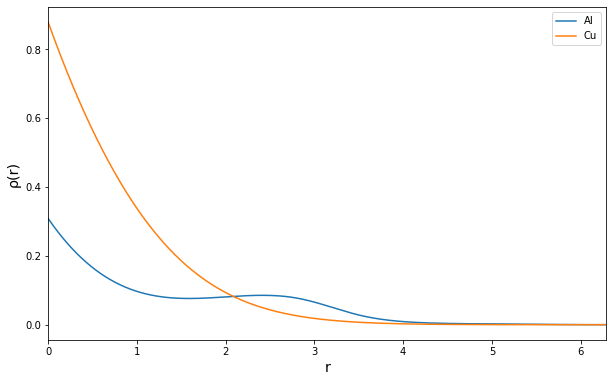

In [13]:
fig = builder.plot_rho_r()
plt.show()

## 4. $\phi(r)$

Conversion notes:

- See conversion notes for 3. $\rho(r)$.
- The plt files tabulate phi(r) while the LAMMPS file tabulates r\*phi(r). The builder will handle the conversion if you set the plt values to phi_r. 

### 4.1. Set phi(r) from the plt files

In [14]:
# Read and set r, phi_r
r, phi_r = read_plt(Path(root, 'Apostol_Mishin_2011_p_Al.plt'), skip=5)
check_final_value(phi_r)
builder.set_phi_r('Al', table=phi_r, r=r)

r, phi_r = read_plt(Path(root, 'Apostol_Mishin_2011_p_Cu.plt'), skip=5)
check_final_value(phi_r)
builder.set_phi_r('Cu', table=phi_r, r=r)

r, phi_r = read_plt(Path(root, 'Apostol_Mishin_2011_p_AlCu.plt'), skip=5)
check_final_value(phi_r)
builder.set_phi_r(['Al', 'Cu'], table=phi_r, r=r)

### 4.2. Plot

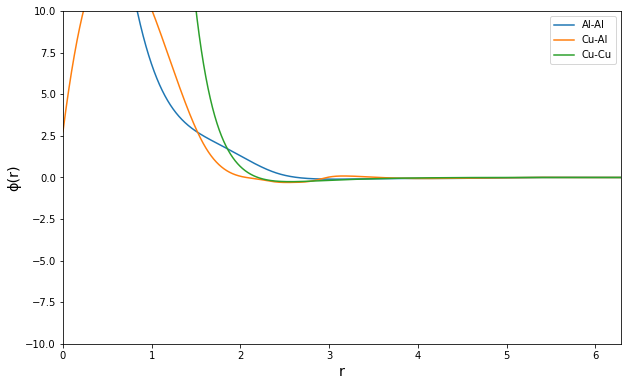

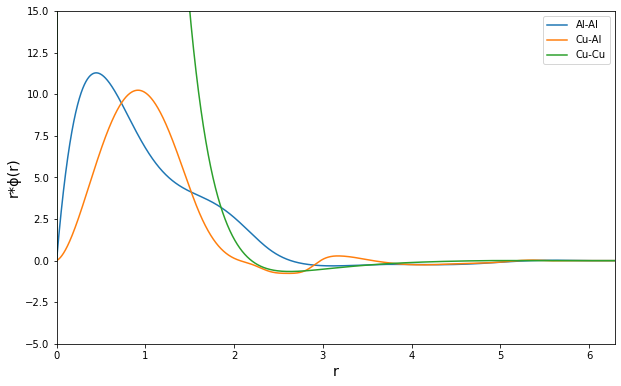

In [15]:
builder.plot_phi_r()
plt.ylim(-10, 10)
plt.show()

builder.plot_rphi_r()
plt.ylim(-5, 15)
plt.show()

## 5. u(r) and w(r) - ADP style only

Conversion notes:

- See conversion notes for 3. $\rho(r)$.

### 5.1. Set u(r) and w(r) from the plt files

In [16]:
# Read and set r, u_r
r, u_r = read_plt(Path(root, 'Apostol_Mishin_2011_d_Al.plt'), skip=5)
check_final_value(u_r)
builder.set_u_r('Al', table=u_r, r=r)

r, u_r = read_plt(Path(root, 'Apostol_Mishin_2011_d_Cu.plt'), skip=5)
check_final_value(u_r)
builder.set_u_r('Cu', table=u_r, r=r)

r, u_r = read_plt(Path(root, 'Apostol_Mishin_2011_d_AlCu.plt'), skip=5)
check_final_value(u_r)
builder.set_u_r(['Al', 'Cu'], table=u_r, r=r)

# Read and set r, w_r
r, w_r = read_plt(Path(root, 'Apostol_Mishin_2011_q_Al.plt'), skip=5)
check_final_value(w_r)
builder.set_w_r('Al', table=w_r, r=r)

r, w_r = read_plt(Path(root, 'Apostol_Mishin_2011_q_Cu.plt'), skip=5)
check_final_value(w_r)
builder.set_w_r('Cu', table=w_r, r=r)

r, w_r = read_plt(Path(root, 'Apostol_Mishin_2011_q_AlCu.plt'), skip=5)
check_final_value(w_r)
builder.set_w_r(['Al', 'Cu'], table=w_r, r=r)

### 5.2. Plot

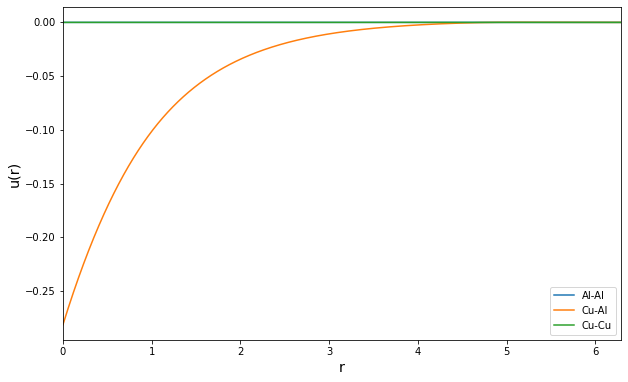

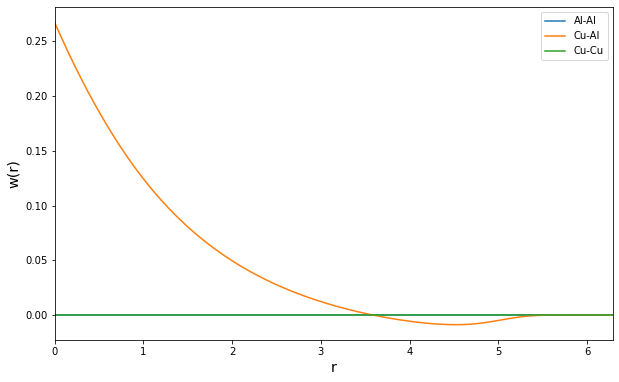

In [17]:
builder.plot_u_r()
#plt.ylim(None, 10)
plt.show()

builder.plot_w_r()
#plt.ylim(-10, 5)
plt.show()

## 6. Build the parameter file

### 6.1. File header lines

The setfl files allow for up to three header comment lines.

In [18]:
builder.header = 'AlCu ADP file converted by Lucas Hale'

### 6.2. Build file

In [42]:
builder.build('AlCu.adp.txt', ncolumns=1)

## 7. Compare with other conversion

In [43]:
ver1 = potentials.paramfile.ADP('F:/website/IPR-website/potentials/Download/2011--Apostol-F-Mishin-Y--Al-Cu/2/AlCu.adp')

In [44]:
ver2 = potentials.paramfile.ADP('AlCu.adp.txt')

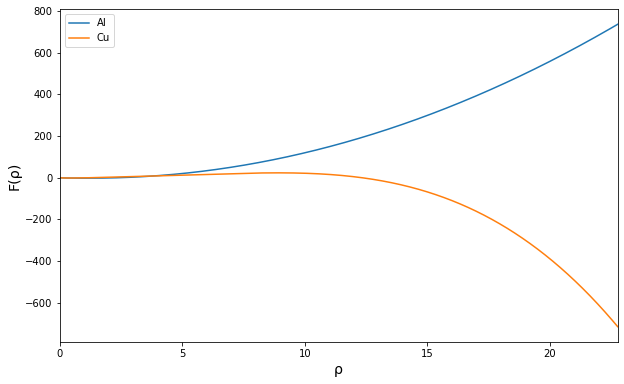

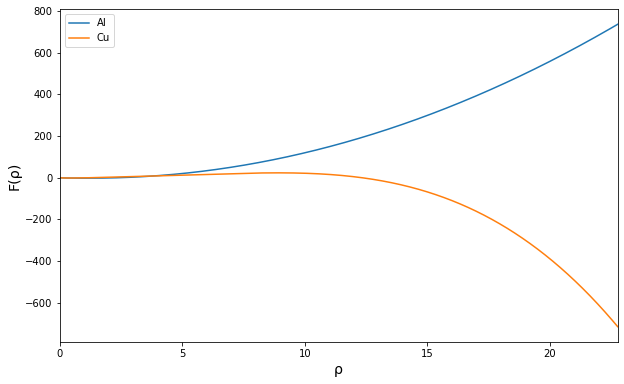

In [22]:
ver1.plot_F_rho()
ver2.plot_F_rho()
None

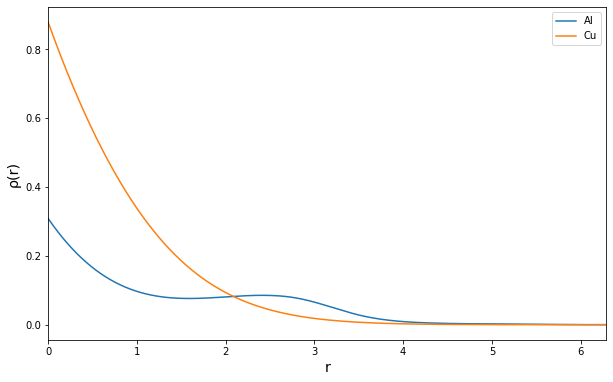

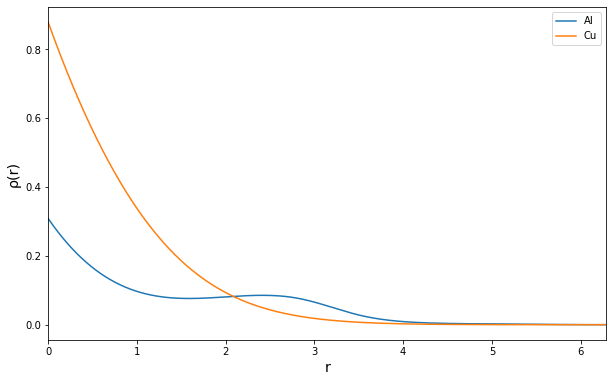

In [23]:
ver1.plot_rho_r()
ver2.plot_rho_r()
None

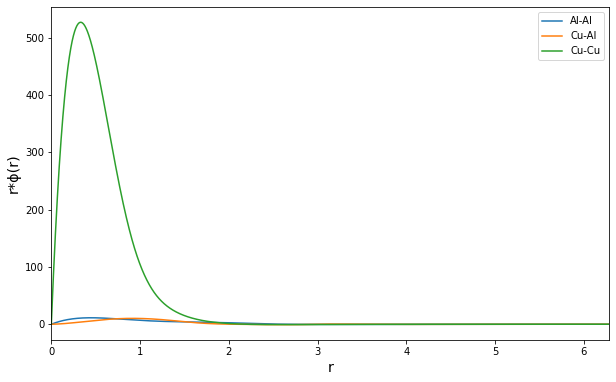

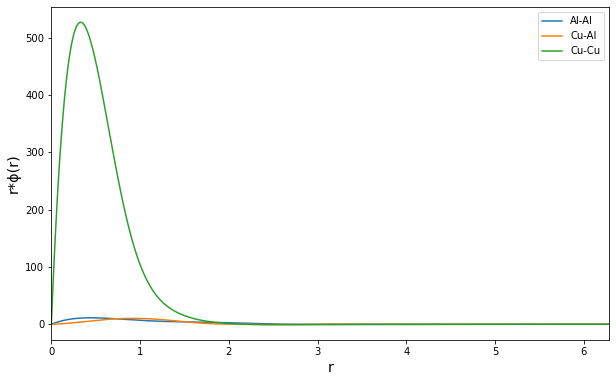

In [24]:
ver1.plot_rphi_r()
ver2.plot_rphi_r()
None

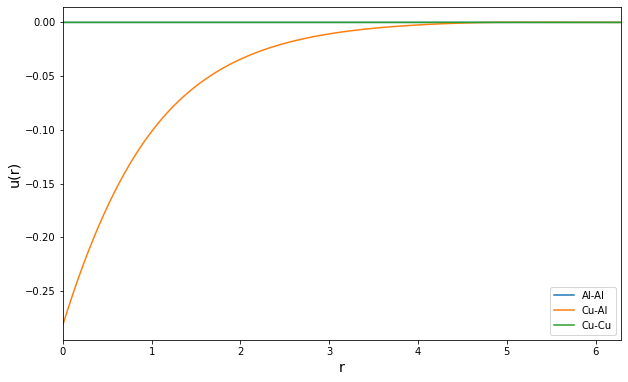

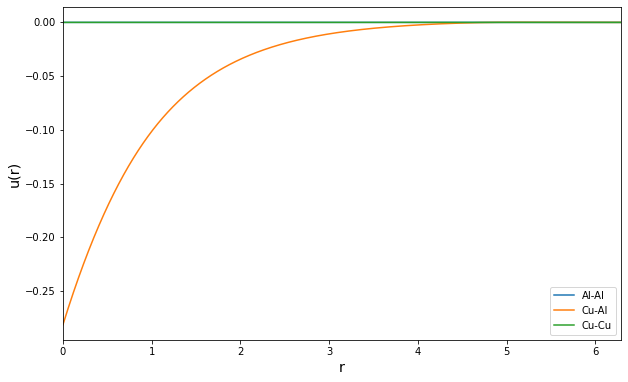

In [25]:
ver1.plot_u_r()
ver2.plot_u_r()
None

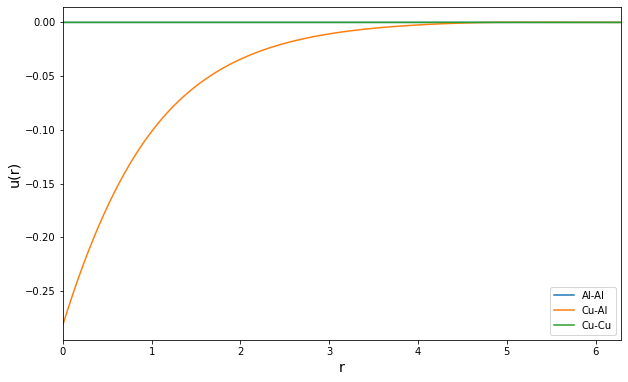

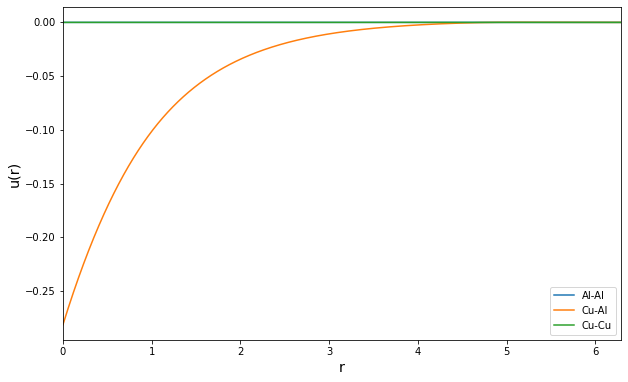

In [25]:
ver1.plot_u_r()
ver2.plot_u_r()
None

In [38]:
max(abs(ver1.F_rho('Cu') - ver2.F_rho('Cu')))

2.6710598878820768e-05

In [63]:
ver1.F_rho('Cu')

array([-2.67105989e-05, -4.32791986e-02, -8.55817198e-02, ...,
       -7.15137110e+02, -7.15457478e+02, -7.15777936e+02])

In [39]:
max(abs(ver1.F_rho('Al') - ver2.F_rho('Al')))

5.878284109472887e-10

In [52]:
max(abs(ver2.rho_r('Al')[:-1] - ver1.rho_r('Al')))

4.499345340747141e-12

In [53]:
max(abs(ver2.rho_r('Cu')[:-1] - ver1.rho_r('Cu')))

2.3314683517128287e-15

In [55]:
max(abs(ver2.rphi_r('Al')[:-1] - ver1.rphi_r('Al')))

6.133049623713305e-11

In [56]:
max(abs(ver2.rphi_r(['Al', 'Cu'])[:-1] - ver1.rphi_r(['Al', 'Cu'])))

1.2189849130095354e-10

In [57]:
max(abs(ver2.w_r('Cu')[:-1] - ver1.w_r('Cu')))

0.0

In [58]:
max(abs(ver2.w_r('Al')[:-1] - ver1.w_r('Al')))

0.0

In [59]:
max(abs(ver2.w_r(['Al', 'Cu'])[:-1] - ver1.w_r(['Al', 'Cu'])))

9.004408330071101e-12

In [60]:
max(abs(ver2.u_r('Cu')[:-1] - ver1.u_r('Cu')))

0.0

In [61]:
max(abs(ver2.u_r('Al')[:-1] - ver1.u_r('Al')))

0.0

In [62]:
max(abs(ver2.u_r(['Al', 'Cu'])[:-1] - ver1.u_r(['Al', 'Cu'])))

1.554312234475219e-14